# Figure S5

### Import packages

In [1]:
import scdiffeq as sdq
import dev
import cellplots as cp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

### Read data and load project

In [2]:
h5ad_path = (
    "/home/mvinyard/data/adata.reprocessed_19OCT2023.more_feature_inclusive.h5ad"
)
adata = sdq.io.read_h5ad(h5ad_path)

AnnData object with n_obs × n_vars = 130887 × 2492
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone_idx', 'fate_observed', 't0_fated', 'train'
    var: 'gene_ids', 'hv_gene', 'must_include', 'exclude', 'use_genes'
    uns: 'fate_counts', 'h5ad_path', 'time_occupance'
    obsm: 'X_clone', 'X_pca', 'X_umap', 'cell_fate_df'
    layers: 'X_scaled'


In [3]:
project = sdq.io.Project(path="./LightningSDE-FixedPotential-RegularizedVelocityRatio/")

### Compute fate prediction accuracy for each version

In [4]:
RATIOS = {}
for version, path in project._VERSION_PATHS.items():
    try:
        v = getattr(project, version)
        acc = dev.fate_prediction_accuracy(v)
        target_ratio = v.hparams["velocity_ratio_params"]["target"]
        RATIOS[version] = target_ratio, v, acc
    except:
        pass

### For each un-regularized training run, compute drift [`f`] and diffusion [`g`]

In [5]:
def f(df, key="training"):
    return df.filter(regex="velo_f").filter(regex=key).dropna().sum(1).mean()


def g(df, key="training"):
    return df.filter(regex="velo_g").filter(regex=key).dropna().sum(1).mean()


UnEnforcedResults = {}
for en, (version, results) in enumerate(RATIOS.items()):
    target_ratio, v, acc = results
    if v.hparams["velocity_ratio_params"]["enforce"] == 0:
        print(version)
        grouped = v.metrics_df.groupby("epoch")
        UnEnforcedResults[version] = {
            "f_training": grouped.apply(f, key="training"),
            "f_validation": grouped.apply(f, key="validation"),
            "g_training": grouped.apply(g, key="training"),
            "g_validation": grouped.apply(g, key="validation"),
        }

version_0
version_1
version_2
version_3
version_4


### Plot un-regularized drift and diffusion

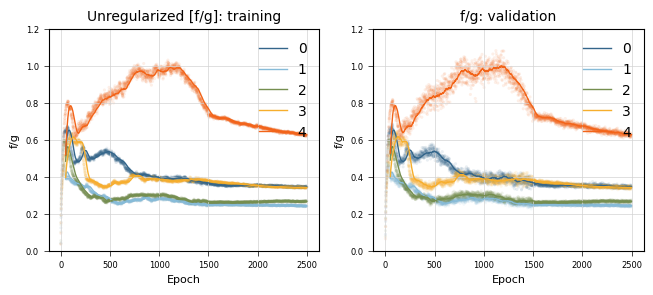

In [6]:
colors = ["#33658a", "#86bbd8", "#758e4f", "#f6ae2d", "#f26419"]

seeds = {
    "version_0": 0,
    "version_1": 1,
    "version_2": 2,
    "version_3": 3,
    "version_4": 4,
}

fig, axes = cp.plot(
    2,
    2,
    wspace=0.2,
    height=0.6,
    width=0.6,
    title=["Unregularized [f/g]: training", "f/g: validation"],
    x_label=["Epoch", "Epoch"],
    y_label=["f/g", "f/g"],
)
for i, (k, v) in enumerate(UnEnforcedResults.items()):
    r_training = v["f_training"].div(v["g_training"])
    r_validation = v["f_validation"].div(v["g_validation"])

    for en, r_df in enumerate([r_training, r_validation]):
        x, y = r_df.index, r_df.values
        xy = r_df.rolling(window=50).mean().dropna()
        c = colors[i]
        axes[en].scatter(
            x, y, c=c, alpha=0.1, s=5, ec="None", zorder=1, rasterized=True
        )
        axes[en].plot(xy, c=c, lw=1, label=seeds[k], zorder=2, rasterized=True)


for ax in axes:
    ax.set_ylim(0, 1.2)
    ax.legend(edgecolor="None", facecolor="None")
    ax.grid(True, c="lightgrey", lw=0.5, zorder=0)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)

plt.savefig(
    "unenforced_drift_diffusion_ration.training_validation.suppl_fig_s5.svg", dpi=500
)

### Compute the empirical unregularized ratio of `f` and `g`

In [7]:
unenforced_ratio = np.array(
    [
        v["f_validation"].iloc[-1] / v["g_validation"].iloc[-1]
        for i, (k, v) in enumerate(UnEnforcedResults.items())
    ]
)
unenforced_ratio.mean(), unenforced_ratio.std()

(0.3669882612570243, 0.13488926187436895)

In [8]:
rel = unenforced_ratio / (1 + unenforced_ratio)
print(rel.mean(), rel.std())
print(unenforced_ratio.mean() / (1 + unenforced_ratio.mean()))

0.26198354528285633 0.06584885182554004
0.2684648227480443
